# Autonomous Vehicles
Build a digit classifier on the SVHN dataset.

In [ ]:
import h5py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
tf.random.set_seed(0)

In [ ]:
file = h5py.File('Autonomous_Vehicles_SVHN_single_grey1.h5', 'r')

In [ ]:
# Keys present in the dataset
file.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = file['X_train'], file['X_test'], file['X_val'], file['y_train'], file['y_test'], file['y_val']

In [ ]:
print('Shape of Input Training Data:', X_train.shape, 'and Data Type:', X_train.dtype)
print('Shape of Label Training Data:', y_train.shape, 'and Data Type:', y_train.dtype)
print('Shape of Input Testing Data:', X_test.shape, 'and Data Type:', X_test.dtype)
print('Shape of Label Testing Data:', y_test.shape, 'and Data Type:', y_test.dtype)
print('Shape of Input Validation Data:', X_val.shape, 'and Data Type:', X_val.dtype)
print('Shape of Label Training Data:', y_val.shape, 'and Data Type:', y_val.dtype)

Shape of Input Training Data: (42000, 32, 32) and Data Type: float32
Shape of Label Training Data: (42000,) and Data Type: uint8
Shape of Input Testing Data: (18000, 32, 32) and Data Type: float32
Shape of Label Testing Data: (18000,) and Data Type: uint8
Shape of Input Validation Data: (60000, 32, 32) and Data Type: float32
Shape of Label Training Data: (60000,) and Data Type: uint8


### Visualizing Train Data

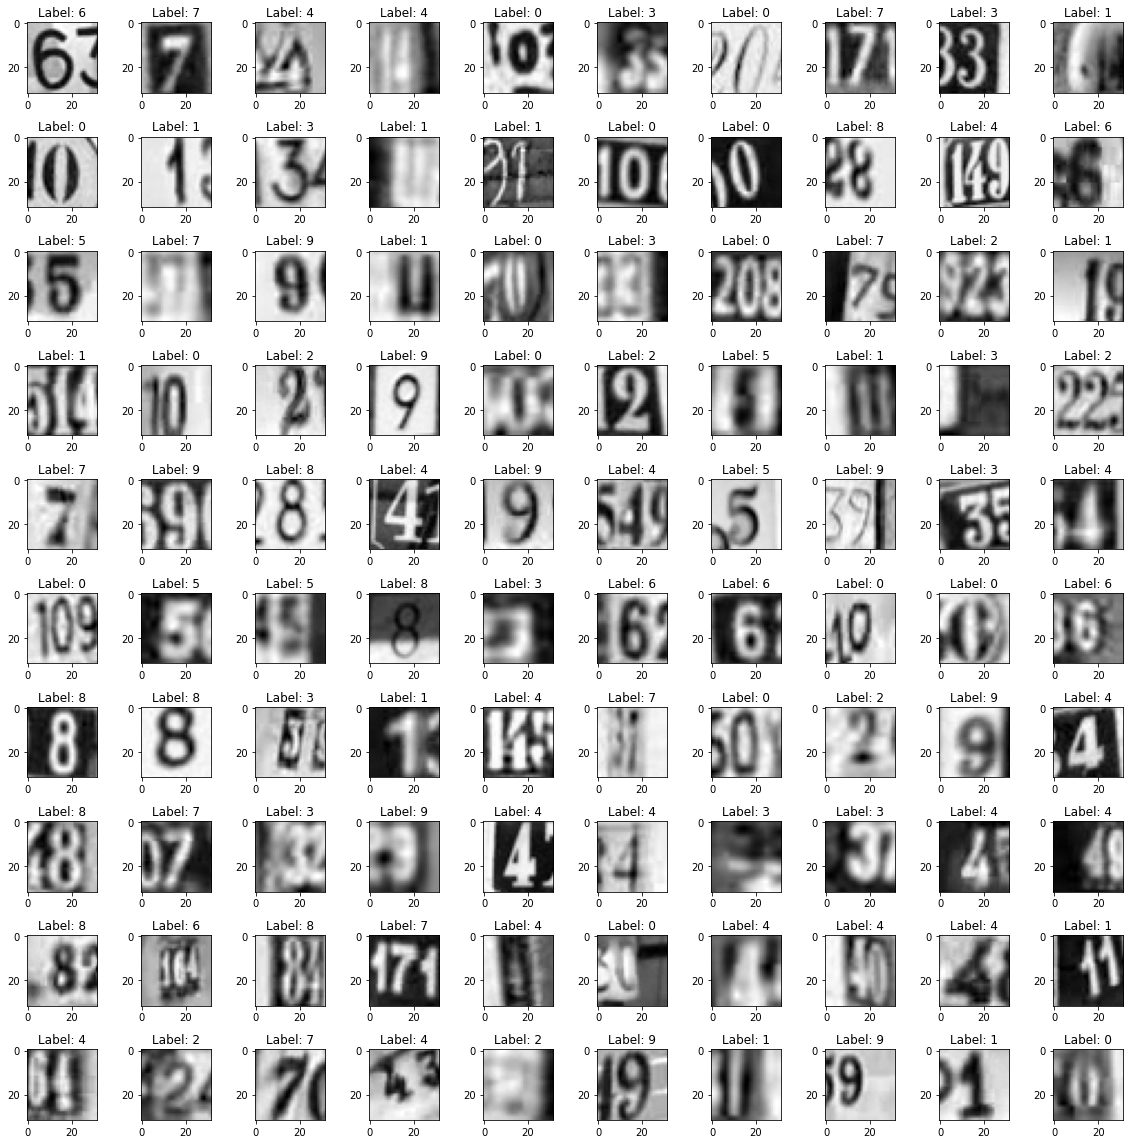

In [ ]:
fig = plt.figure(figsize=(16, 16))
columns = 10
rows = 10
for i in range(1, columns*rows+1):
  img = X_train[i]
  ax = fig.add_subplot(rows, columns, i, title=y_test[i])
  ax.set_title('Label: ' + str(y_train[i]))
  plt.imshow(img, cmap='gray')
fig.tight_layout()
plt.show()

### Visualizing Test Data

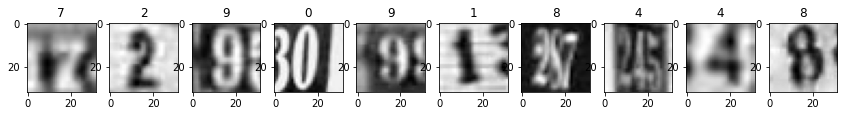

In [ ]:
fig1 = plt.figure(figsize=(16, 16))
for i in range(1, 11):
  img = X_test[i]
  ax = fig1.add_subplot(1, 11, i, title=y_test[i])
  plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# Unique output columns
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

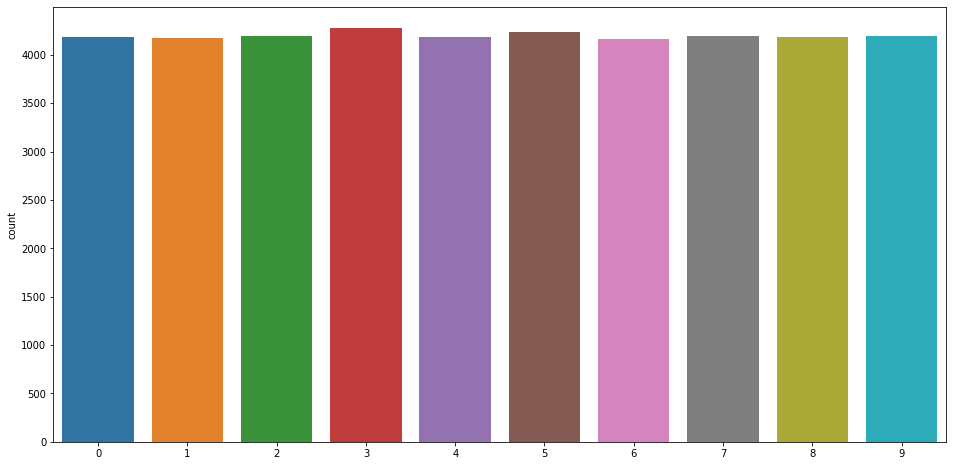

In [ ]:
plt.figure(figsize=(16, 8))
sns.countplot(x=np.array(y_train))
plt.show()

### Observations:
1. The images are not having just single digit.
2. Multiple images contain various digits although the respective label is having only a single digit.
3. The data for the classes are present in almost equal so the class imabalanced issue will not be there

###### Reshaping the input data

In [ ]:
X_train = np.array(X_train).reshape(42000, 1024)
X_test = np.array(X_test).reshape(18000, 1024)
X_val = np.array(X_val).reshape(60000, 1024)

###### Normalizing the input data

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

###### Converting the target values as categorical

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

In [ ]:
def create_model(layers, optimizer, loss, metrics, epochs, batch_size, callbacks):
  model = tf.keras.Sequential()
  for layer in layers:
    model.add(layer)  
  print(model.summary())

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=callbacks)
  return history

##### Iteration 1: Training a simple neural network with 5 Dense layer



In [ ]:
layers = [
  tf.keras.layers.Dense(32, input_shape=(1024,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(500, activation='relu'),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
]

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_1', verbose=2, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

history_itr_1 = create_model(layers, 'sgd', 'categorical_crossentropy', ['accuracy'], 100, 128, callbacks)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 32)                32800     
_________________________________________________________________
dense_70 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_71 (Dense)             (None, 500)               64500     
_________________________________________________________________
dense_72 (Dense)             (None, 50)                25050     
_________________________________________________________________
dense_73 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_74 (Dense)             (None, 10)                510       
Total params: 129,634
Trainable params: 129,634
Non-trainable params: 0
_______________________________________________

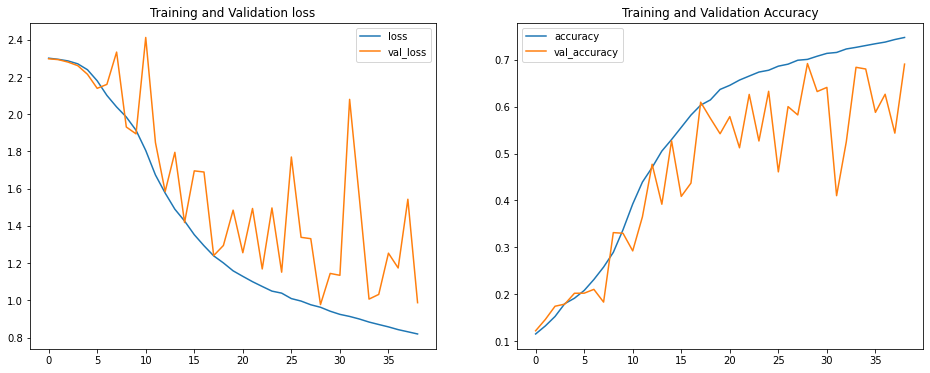

In [ ]:
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1, title='Training and Validation loss')
plt.plot(history_itr_1.epoch, history_itr_1.history['loss'])
plt.plot(history_itr_1.epoch, history_itr_1.history['val_loss'])
plt.legend(['loss', 'val_loss'])

fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
plt.plot(history_itr_1.epoch, history_itr_1.history['accuracy'])
plt.plot(history_itr_1.epoch, history_itr_1.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

### Observation: 

The training accuracy is good but the validation accuracy is low. As the difference between training and validation is accuracy is also more, so we can conclude the model is overfitting.

##### Iteration 2: Initializing kernel_initializer for each dense layer

In [ ]:
layers = [
  tf.keras.layers.Dense(32, input_shape=(1024,)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(500, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(10, activation='softmax')
]

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_2', verbose=2, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

history_itr_2 = create_model(layers, 'sgd', 'categorical_crossentropy', ['accuracy'], 100, 128, callbacks)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 32)                32800     
_________________________________________________________________
dense_76 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_77 (Dense)             (None, 500)               64500     
_________________________________________________________________
dense_78 (Dense)             (None, 50)                25050     
_________________________________________________________________
dense_79 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_80 (Dense)             (None, 10)                510       
Total params: 129,634
Trainable params: 129,634
Non-trainable params: 0
_______________________________________________

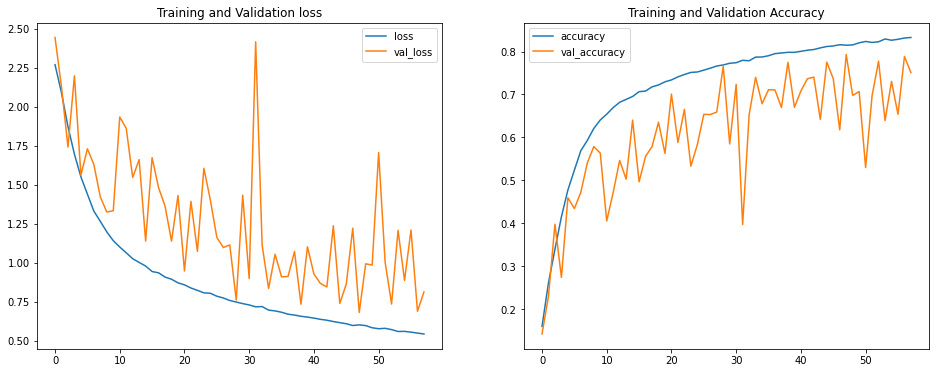

In [ ]:
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1, title='Training and Validation loss')
plt.plot(history_itr_2.epoch, history_itr_2.history['loss'])
plt.plot(history_itr_2.epoch, history_itr_2.history['val_loss'])
plt.legend(['loss', 'val_loss'])

fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
plt.plot(history_itr_2.epoch, history_itr_2.history['accuracy'])
plt.plot(history_itr_2.epoch, history_itr_2.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

### Observations:
This is performing better than 1st iteration as the difference between training and validation accuracy is decreased. In the next iteration, we will try adding more layers and check.

##### Iteration 3: Adding BatchNormalization layer after each Dense layer

In [ ]:
layers = [
  tf.keras.layers.Dense(32, input_shape=(1024,)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(500, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation='softmax')
]

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_3', verbose=2, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

history_itr_3 = create_model(layers, 'sgd', 'categorical_crossentropy', ['accuracy'], 100, 128, callbacks)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 32)                32800     
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
dense_82 (Dense)             (None, 128)               4224      
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512       
_________________________________________________________________
dense_83 (Dense)             (None, 500)               64500     
_________________________________________________________________
batch_normalization_22 (Batc (None, 500)               2000      
_________________________________________________________________
dense_84 (Dense)             (None, 50)              

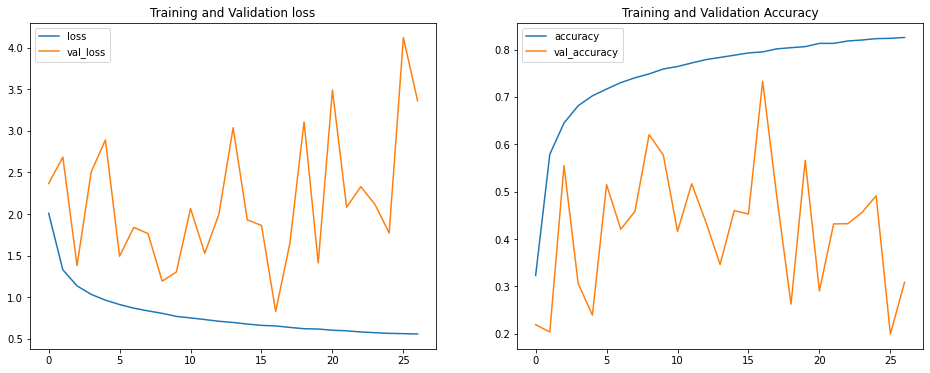

In [ ]:
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1, title='Training and Validation loss')
plt.plot(history_itr_3.epoch, history_itr_3.history['loss'])
plt.plot(history_itr_3.epoch, history_itr_3.history['val_loss'])
plt.legend(['loss', 'val_loss'])

fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
plt.plot(history_itr_3.epoch, history_itr_3.history['accuracy'])
plt.plot(history_itr_3.epoch, history_itr_3.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

### Observations:
As we can see, there is big drop in validation accuracy with compare to the previous iteration. We will try with reducing BatchNormalization layer and adding Dropout layers

##### Iteration 4: Reducing BatchNormalization and adding Dropout layer

In [ ]:
layers = [
  tf.keras.layers.Dense(32, input_shape=(1024,)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(500, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
   tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(500, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation='softmax')
]

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_4', verbose=2, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

history_itr_4 = create_model(layers, 'sgd', 'categorical_crossentropy', ['accuracy'], 100, 128, callbacks)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 32)                32800     
_________________________________________________________________
batch_normalization_25 (Batc (None, 32)                128       
_________________________________________________________________
dense_88 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 500)               64500     
_________________________________________________________________
batch_normalization_26 (Batc (None, 500)               2000      
_________________________________________________________________
dense_90 (Dense)             (None, 50)              

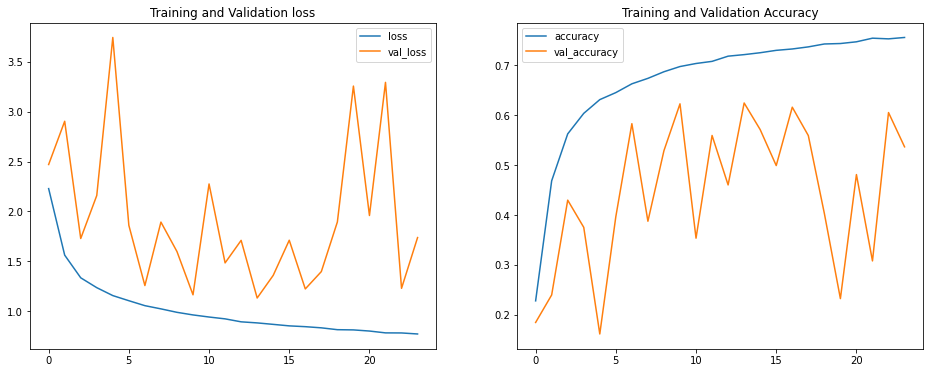

In [ ]:
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1, title='Training and Validation loss')
plt.plot(history_itr_4.epoch, history_itr_4.history['loss'])
plt.plot(history_itr_4.epoch, history_itr_4.history['val_loss'])
plt.legend(['loss', 'val_loss'])

fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
plt.plot(history_itr_4.epoch, history_itr_4.history['accuracy'])
plt.plot(history_itr_4.epoch, history_itr_4.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

### Observations:
In the last 4 iterations, iteration 2 has given better results where training and validation accuracy difference was less and validation loss also was 0.6 only. So based on this, we have finalized the layer, now we will use different optimizer and improve the model.

##### Iteration 5: SGD Optimizer with momentum and learning rate

In [ ]:
layers = [
  tf.keras.layers.Dense(32, input_shape=(1024,)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(500, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(10, activation='softmax')
]

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_5', verbose=2, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

sgd = tf.keras.optimizers.SGD(lr = 0.001, momentum=0.9)
history_itr_5 = create_model(layers, 'sgd', 'categorical_crossentropy', ['accuracy'], 100, 128, callbacks)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 32)                32800     
_________________________________________________________________
dense_94 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_95 (Dense)             (None, 500)               64500     
_________________________________________________________________
dense_96 (Dense)             (None, 50)                25050     
_________________________________________________________________
dense_97 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_98 (Dense)             (None, 10)                510       
Total params: 129,634
Trainable params: 129,634
Non-trainable params: 0
_______________________________________________

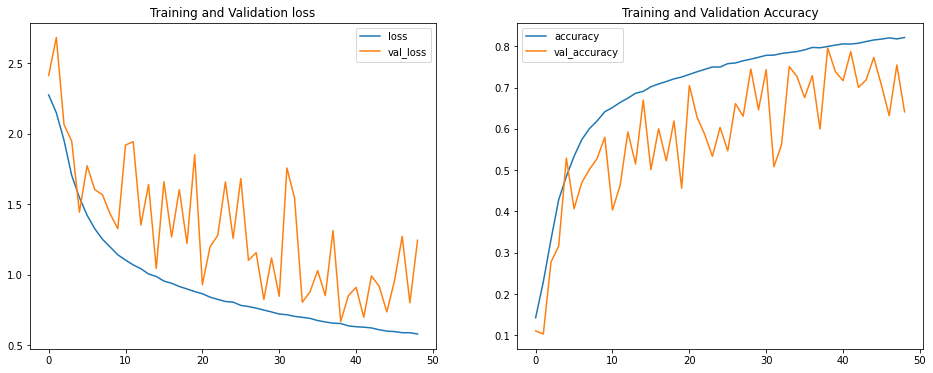

In [ ]:
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1, title='Training and Validation loss')
plt.plot(history_itr_5.epoch, history_itr_5.history['loss'])
plt.plot(history_itr_5.epoch, history_itr_5.history['val_loss'])
plt.legend(['loss', 'val_loss'])

fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
plt.plot(history_itr_5.epoch, history_itr_5.history['accuracy'])
plt.plot(history_itr_5.epoch, history_itr_5.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

##### Iteration 6: Lets try Adam as optimizer

In [ ]:
layers = [
  tf.keras.layers.Dense(32, input_shape=(1024,)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(500, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(10, activation='softmax')
]

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_6', verbose=2, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

history_itr_6 = create_model(layers, 'adam', 'categorical_crossentropy', ['accuracy'], 100, 128, callbacks)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 32)                32800     
_________________________________________________________________
dense_100 (Dense)            (None, 128)               4224      
_________________________________________________________________
dense_101 (Dense)            (None, 500)               64500     
_________________________________________________________________
dense_102 (Dense)            (None, 50)                25050     
_________________________________________________________________
dense_103 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_104 (Dense)            (None, 10)                510       
Total params: 129,634
Trainable params: 129,634
Non-trainable params: 0
_______________________________________________

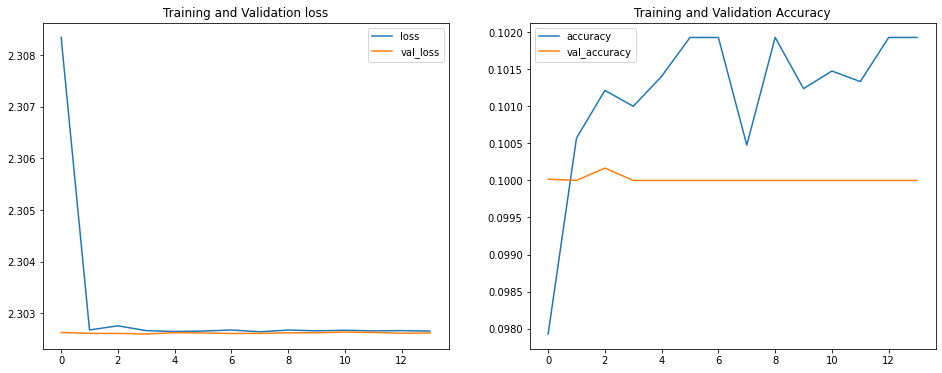

In [ ]:
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1, title='Training and Validation loss')
plt.plot(history_itr_6.epoch, history_itr_6.history['loss'])
plt.plot(history_itr_6.epoch, history_itr_6.history['val_loss'])
plt.legend(['loss', 'val_loss'])

fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
plt.plot(history_itr_6.epoch, history_itr_6.history['accuracy'])
plt.plot(history_itr_6.epoch, history_itr_6.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

### Observations:
Adam is performing very poorly with Dense layers, we have to add layers and try using adam as an optimizer.

##### Iteration 7: Adding BatchNormalization layer and Adam as optimizer


In [ ]:
layers = [
  tf.keras.layers.Dense(32, input_shape=(1024,)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(500, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation='softmax')
]

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_7', verbose=2, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

history_itr_7 = create_model(layers, 'adam', 'categorical_crossentropy', ['accuracy'], 100, 128, callbacks)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 32)                32800     
_________________________________________________________________
dense_124 (Dense)            (None, 128)               4224      
_________________________________________________________________
batch_normalization_40 (Batc (None, 128)               512       
_________________________________________________________________
dense_125 (Dense)            (None, 500)               64500     
_________________________________________________________________
batch_normalization_41 (Batc (None, 500)               2000      
_________________________________________________________________
dense_126 (Dense)            (None, 50)                25050     
_________________________________________________________________
batch_normalization_42 (Batc (None, 50)              

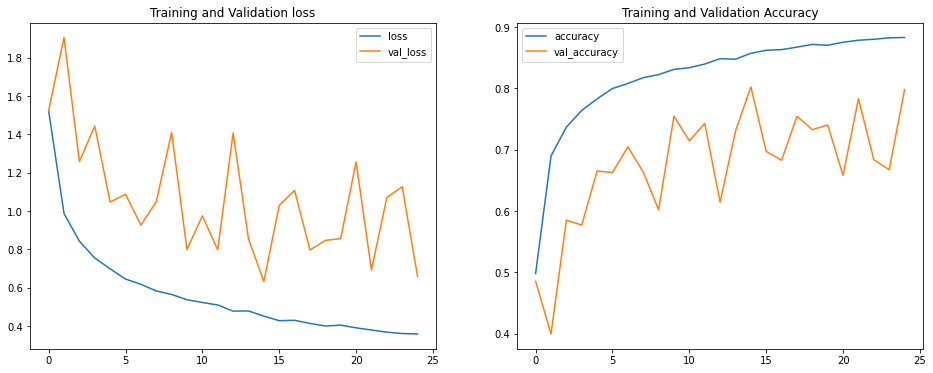

In [ ]:
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1, title='Training and Validation loss')
plt.plot(history_itr_7.epoch, history_itr_7.history['loss'])
plt.plot(history_itr_7.epoch, history_itr_7.history['val_loss'])
plt.legend(['loss', 'val_loss'])

fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
plt.plot(history_itr_7.epoch, history_itr_7.history['accuracy'])
plt.plot(history_itr_7.epoch, history_itr_7.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

### Observations:
As we can observe, adam is performing better with added layers and having better accuracy.

##### Iteration 8: Optimizing Adam optimizer


In [ ]:
layers = [
  tf.keras.layers.Dense(32, input_shape=(1024,)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(500, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation='softmax')
]

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_8', verbose=2, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)
history_itr_8 = create_model(layers, adam, 'categorical_crossentropy', ['accuracy'], 100, 128, callbacks)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 32)                32800     
_________________________________________________________________
dense_130 (Dense)            (None, 128)               4224      
_________________________________________________________________
batch_normalization_44 (Batc (None, 128)               512       
_________________________________________________________________
dense_131 (Dense)            (None, 500)               64500     
_________________________________________________________________
batch_normalization_45 (Batc (None, 500)               2000      
_________________________________________________________________
dense_132 (Dense)            (None, 50)                25050     
_________________________________________________________________
batch_normalization_46 (Batc (None, 50)              

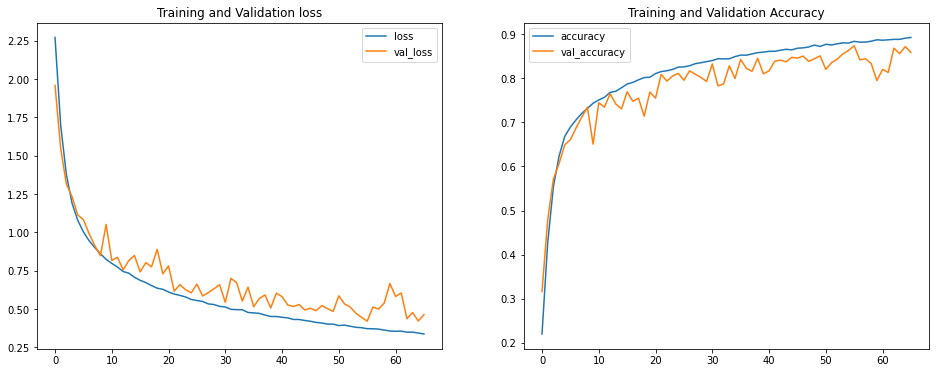

In [ ]:
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1, title='Training and Validation loss')
plt.plot(history_itr_8.epoch, history_itr_8.history['loss'])
plt.plot(history_itr_8.epoch, history_itr_8.history['val_loss'])
plt.legend(['loss', 'val_loss'])

fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
plt.plot(history_itr_8.epoch, history_itr_8.history['accuracy'])
plt.plot(history_itr_8.epoch, history_itr_8.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

### Observations:
Iteration 8 is performing best, the training and validation accuracy is good and the difference between both also is less. Also, the validation loss is only 0.44 which is best among all the iterations.

Iteration 9: Increasing batch size and epochs

In [ ]:
layers = [
  tf.keras.layers.Dense(32, input_shape=(1024,)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(500, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation='softmax')
]

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='weights_itr_9', verbose=2, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)
history_itr_9 = create_model(layers, adam, 'categorical_crossentropy', ['accuracy'], 200, 500, callbacks)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 32)                32800     
_________________________________________________________________
dense_142 (Dense)            (None, 128)               4224      
_________________________________________________________________
batch_normalization_52 (Batc (None, 128)               512       
_________________________________________________________________
dense_143 (Dense)            (None, 500)               64500     
_________________________________________________________________
batch_normalization_53 (Batc (None, 500)               2000      
_________________________________________________________________
dense_144 (Dense)            (None, 50)                25050     
_________________________________________________________________
batch_normalization_54 (Batc (None, 50)              

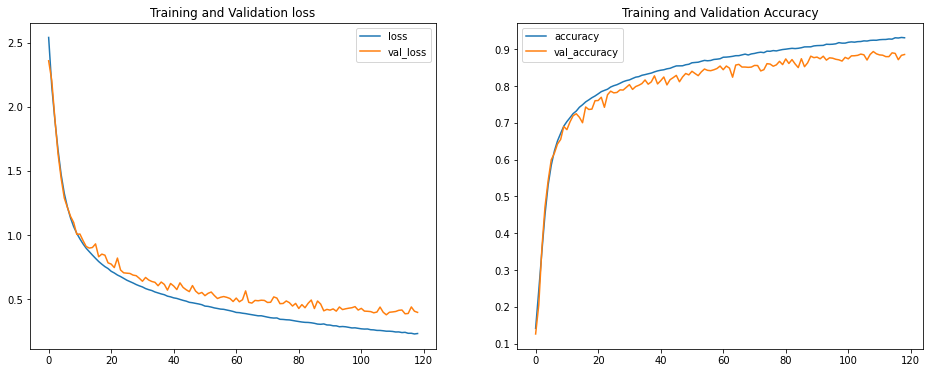

In [ ]:
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1, title='Training and Validation loss')
plt.plot(history_itr_9.epoch, history_itr_9.history['loss'])
plt.plot(history_itr_9.epoch, history_itr_9.history['val_loss'])
plt.legend(['loss', 'val_loss'])

fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
plt.plot(history_itr_9.epoch, history_itr_9.history['accuracy'])
plt.plot(history_itr_9.epoch, history_itr_9.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

### Observations:
Iteration 9 has given the best accuracy and validation loss has been further reduced. So iteration 9 model will be considered for final model and will test out the accuracy and confusion matrix on the test dataset. 

#### Building the final model

In [ ]:
classifier = tf.keras.Sequential([
  tf.keras.layers.Dense(32, input_shape=(1024,)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(500, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
classifier.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 32)                32800     
_________________________________________________________________
dense_154 (Dense)            (None, 128)               4224      
_________________________________________________________________
batch_normalization_60 (Batc (None, 128)               512       
_________________________________________________________________
dense_155 (Dense)            (None, 500)               64500     
_________________________________________________________________
batch_normalization_61 (Batc (None, 500)               2000      
_________________________________________________________________
dense_156 (Dense)            (None, 50)                25050     
_________________________________________________________________
batch_normalization_62 (Batc (None, 50)              

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)
classifier.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='final_weights', verbose=2, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=500, verbose=2, callbacks=callbacks)

Epoch 1/200
84/84 - 2s - loss: 2.6090 - accuracy: 0.1459 - val_loss: 2.3109 - val_accuracy: 0.1233

Epoch 00001: val_loss improved from inf to 2.31087, saving model to final_weights
INFO:tensorflow:Assets written to: final_weights/assets
Epoch 2/200
84/84 - 1s - loss: 2.1590 - accuracy: 0.2454 - val_loss: 2.1757 - val_accuracy: 0.2088

Epoch 00002: val_loss improved from 2.31087 to 2.17568, saving model to final_weights
INFO:tensorflow:Assets written to: final_weights/assets
Epoch 3/200
84/84 - 1s - loss: 1.8774 - accuracy: 0.3501 - val_loss: 1.9367 - val_accuracy: 0.3171

Epoch 00003: val_loss improved from 2.17568 to 1.93674, saving model to final_weights
INFO:tensorflow:Assets written to: final_weights/assets
Epoch 4/200
84/84 - 1s - loss: 1.6666 - accuracy: 0.4394 - val_loss: 1.6543 - val_accuracy: 0.4478

Epoch 00004: val_loss improved from 1.93674 to 1.65434, saving model to final_weights
INFO:tensorflow:Assets written to: final_weights/assets
Epoch 5/200
84/84 - 1s - loss: 1.495

In [ ]:
pred_ = np.argmax(classifier.predict(X_test), axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

In [ ]:
lb = LabelBinarizer()
predict_label = lb.fit_transform(pred_)

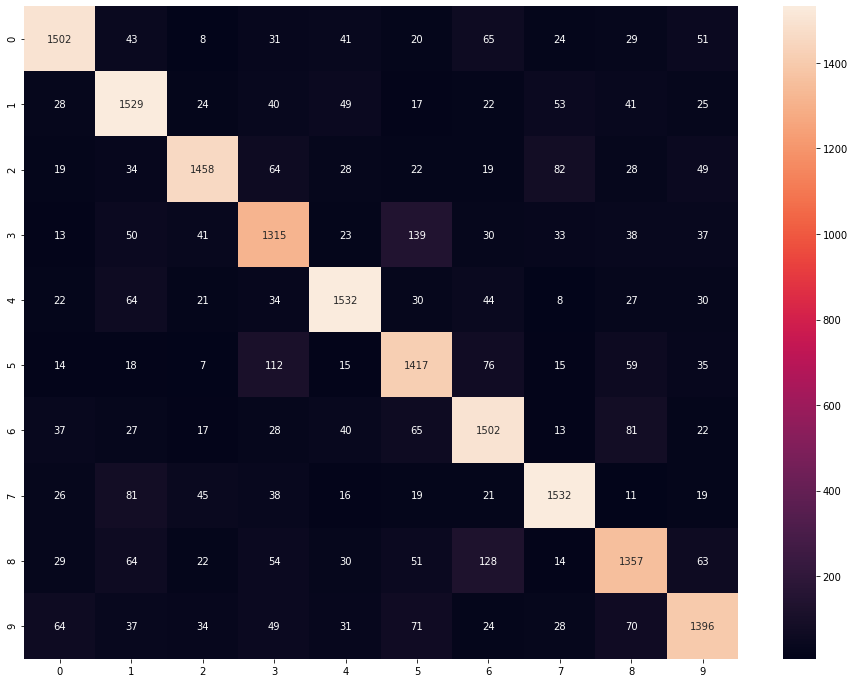

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(confusion_matrix(y_test.argmax(axis=1), pred_, labels=lb.classes_), fmt='g', annot=True)
plt.show()

In [ ]:
print(classification_report(y_test.argmax(axis=1), pred_))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1814
           1       0.79      0.84      0.81      1828
           2       0.87      0.81      0.84      1803
           3       0.75      0.76      0.75      1719
           4       0.85      0.85      0.85      1812
           5       0.77      0.80      0.78      1768
           6       0.78      0.82      0.80      1832
           7       0.85      0.85      0.85      1808
           8       0.78      0.75      0.76      1812
           9       0.81      0.77      0.79      1804

    accuracy                           0.81     18000
   macro avg       0.81      0.81      0.81     18000
weighted avg       0.81      0.81      0.81     18000



### Conclusion
We have used deep neural network to recognize the digits in SVHN dataset. The model is performing good enough and able to recognize all classes almost equally. Further, the model can improved using Convolutional layers.